In [48]:
!pip install pmdarima

In [49]:
# @title Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# @title Configuración rutas
root = '/content/drive/MyDrive/Desarrollo de Software/'
compras_route = f'{root}/Investigación/CBA-Hogar.xlsx'
ipc_route = f'{root}/Investigación/IPC.xlsx'

In [51]:
#compras_df = pd.read_excel(compras_route)
#compras_df = pd.read_excel(compras_route, parse_dates=["Fecha"], index_col='Fecha')
compras_df = pd.read_excel(compras_route)
ipc_df = pd.read_excel(ipc_route)

compras_df['IPC'] = ipc_df['IPC']
compras_df['Fecha'] = pd.to_datetime(compras_df['Fecha'])
compras_df = compras_df.set_index('Fecha')
compras_df = compras_df.asfreq('MS')

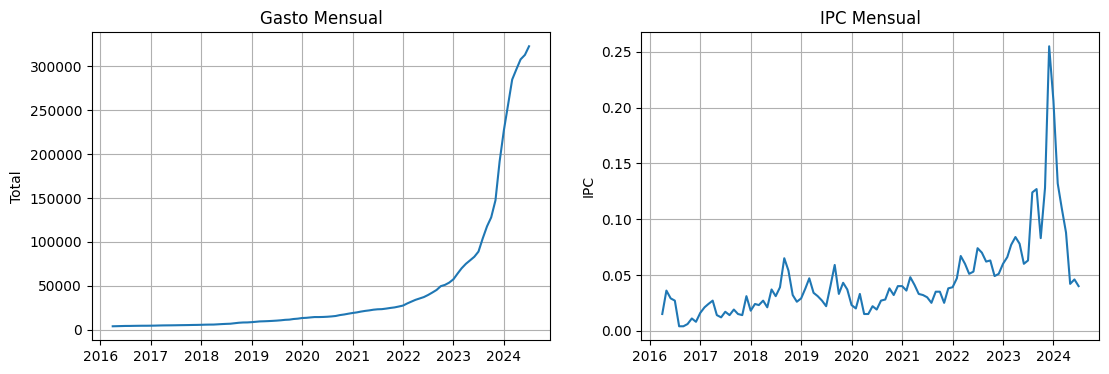

In [52]:
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(compras_df.index, compras_df['Total'])
plt.title('Gasto Mensual')
plt.ylabel('Total')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(compras_df.index, compras_df['IPC'])
plt.title('IPC Mensual')
plt.ylabel('IPC')
plt.grid()

plt.show()

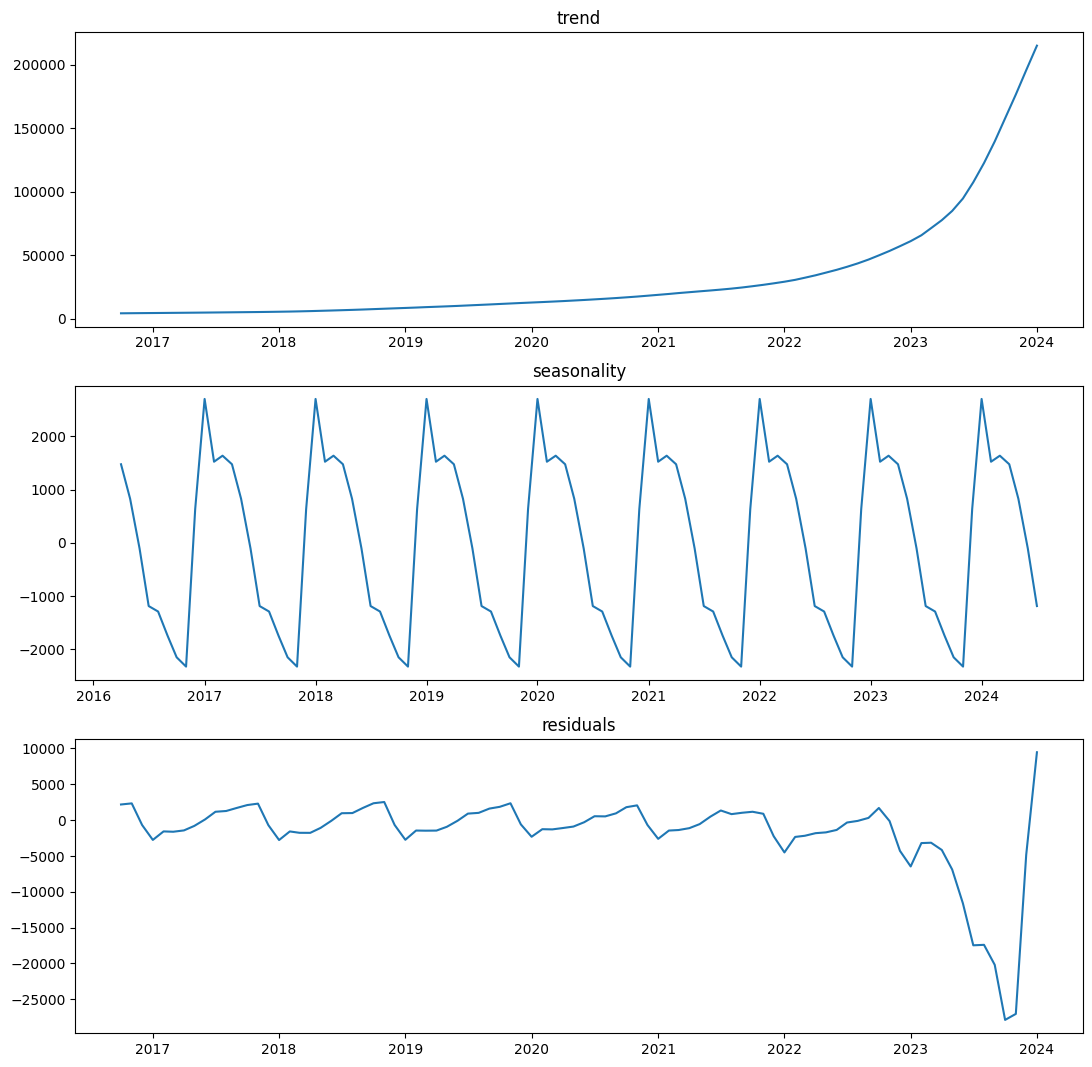

In [53]:
result_decompose = seasonal_decompose(compras_df['Total'], model='additive')
trend     = result_decompose.trend
seasonal  = result_decompose.seasonal
residuals = result_decompose.resid

plt.figure(figsize=(13,13))
plt.subplot(311)
plt.plot(trend)
plt.title('trend')
plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')
plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')
plt.show()

In [54]:
# Dividir los datos en entrenamiento y prueba
train_size = len(compras_df) - 3
train, test = compras_df[:train_size], compras_df[train_size:]
print(f"Tamaño de entrenamiento: {len(train)}")
print(f"Tamaño de prueba: {len(test)}")

Tamaño de entrenamiento: 97
Tamaño de prueba: 3


In [55]:
auto_arima_model = pm.auto_arima(y=train['Total'],
                              x=train['IPC'],
                              seasonal=True,
                              m=12,
                              information_criterion="aic",
                              trace=True,
                              stepwise=False,
                              suppress_warnings=True)

model = SARIMAX(endog=train['Total'],
                exog=train['IPC'],
                order=auto_arima_model.order,
                seasonal_order=auto_arima_model.seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1609.779, Time=0.05 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=1610.791, Time=0.79 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=inf, Time=3.68 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=1610.870, Time=2.42 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=inf, Time=4.17 sec
 ARIMA(0,2,0)(1,1,2)[12]             : AIC=inf, Time=5.34 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=1612.650, Time=1.80 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=1614.631, Time=11.02 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AIC=inf, Time=5.04 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=1606.925, Time=0.12 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=1609.018, Time=0.18 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=1611.018, Time=1.31 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=1609.026, Time=0.56 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=1611.016, Time=1.99 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=1613.018, Time=1.93 sec
 ARIMA(0,2,1)(

In [56]:
# Realizar predicciones
forecast_steps = len(test)
forecast = model_fit.forecast(steps = forecast_steps, exog=test['IPC'])

forecast_index = test.index
forecast_series = pd.Series(data=forecast, index=forecast_index)

for fecha, forecast, actual, ipc in zip(test.index, forecast_series.round(2), test['Total'], test['IPC']):
    print(f"Fecha: {fecha.strftime('%m / %Y')}, Predicción: {forecast:.2f}, Real: {actual:.2f}, IPC: {ipc}")

Fecha: 05 / 2024, Predicción: 302442.89, Real: 308079.31, IPC: 0.042
Fecha: 06 / 2024, Predicción: 318058.84, Real: 313127.96, IPC: 0.046
Fecha: 07 / 2024, Predicción: 337617.68, Real: 322982.18, IPC: 0.04


In [57]:
errors = forecast_series - test['Total']
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / test['Total'])) * 100

print("Errores de Predicción:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Errores de Predicción:
MAE: 8400.93
MSE: 90093556.67
RMSE: 9491.76
MAPE: 2.65%


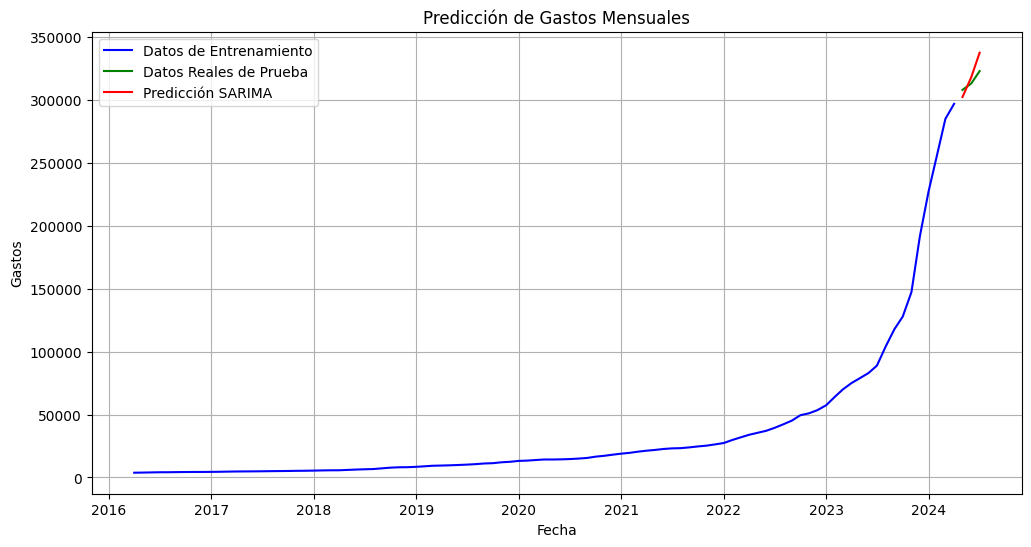

In [58]:
# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total'], label='Datos de Entrenamiento', color='blue')
plt.plot(test.index, test['Total'], label='Datos Reales de Prueba', color='green')
plt.plot(forecast_series.index, forecast_series, color='red', label='Predicción SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Gastos')
plt.title('Predicción de Gastos Mensuales')
plt.legend()
plt.grid(True)

plt.show()

# SIN IPC

In [59]:
auto_arima_model = pm.auto_arima(y=train['Total'],
                              seasonal=True,
                              m=12,
                              information_criterion="aic",
                              trace=True,
                              stepwise=True,
                              suppress_warnings=True)

model = SARIMAX(endog=train['Total'],
                order=auto_arima_model.order,
                seasonal_order=auto_arima_model.seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,1,1)[12]             : AIC=1600.389, Time=5.33 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1609.779, Time=0.08 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1612.360, Time=0.47 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=1609.018, Time=0.17 sec
 ARIMA(2,2,2)(0,1,1)[12]             : AIC=1599.066, Time=0.64 sec
 ARIMA(2,2,2)(0,1,0)[12]             : AIC=1598.203, Time=0.24 sec
 ARIMA(2,2,2)(1,1,0)[12]             : AIC=1598.395, Time=0.72 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=1595.743, Time=0.29 sec
 ARIMA(1,2,2)(1,1,0)[12]             : AIC=1595.311, Time=1.01 sec
 ARIMA(1,2,2)(2,1,0)[12]             : AIC=1597.293, Time=2.18 sec
 ARIMA(1,2,2)(1,1,1)[12]             : AIC=1598.613, Time=1.27 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=1597.257, Time=0.52 sec
 ARIMA(1,2,2)(2,1,1)[12]             : AIC=1600.620, Time=1.07 sec
 ARIMA(0,2,2)(1,1,0)[12]             : AIC=1596.157, Time=0.53 sec
 ARIMA(1,2,1)(1,1,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                   97
Model:             SARIMAX(1, 2, 2)x(1, 1, [], 12)   Log Likelihood                -792.656
Date:                             Mon, 07 Oct 2024   AIC                           1595.311
Time:                                     17:28:56   BIC                           1607.405
Sample:                                 04-01-2016   HQIC                          1600.170
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3822      0.195      1.958      0.050      -0.000       0.765
ma.L1         -0.1181      

In [60]:
# Realizar predicciones
forecast_steps = len(test)
forecast = model_fit.forecast(steps = forecast_steps)

forecast_index = test.index
forecast_series = pd.Series(data=forecast, index=forecast_index)

for fecha, forecast, actual in zip(test.index, forecast_series.round(2), test['Total']):
    print(f"Fecha: {fecha.strftime('%m / %Y')}, Predicción: {forecast:.2f}, Real: {actual:.2f}")

Fecha: 05 / 2024, Predicción: 303521.82, Real: 308079.31
Fecha: 06 / 2024, Predicción: 316008.32, Real: 313127.96
Fecha: 07 / 2024, Predicción: 333205.97, Real: 322982.18


In [61]:
errors = forecast_series - test['Total']
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / test['Total'])) * 100

print("Errores de Predicción:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Errores de Predicción:
MAE: 5887.21
MSE: 44531013.73
RMSE: 6673.16
MAPE: 1.85%


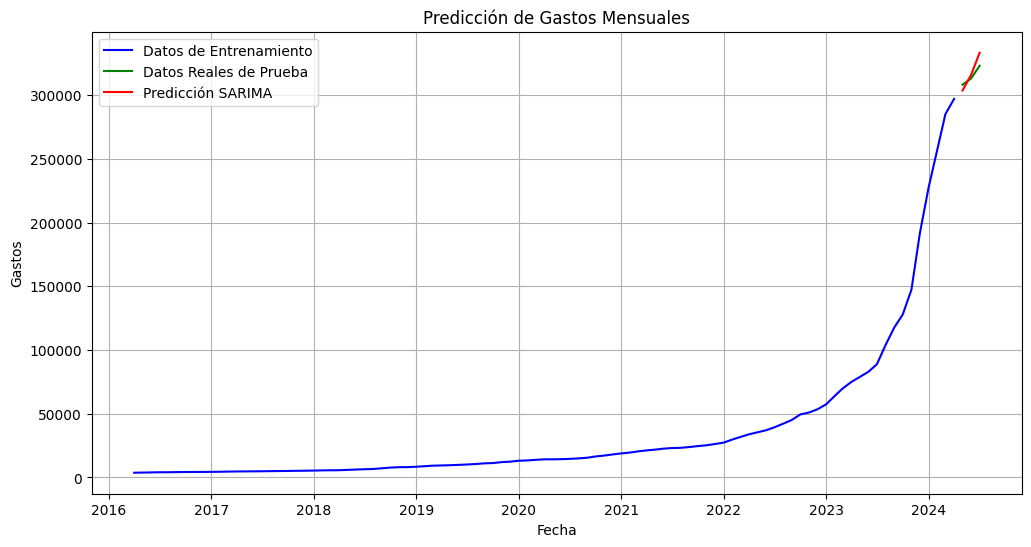

In [62]:
# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total'], label='Datos de Entrenamiento', color='blue')
plt.plot(test.index, test['Total'], label='Datos Reales de Prueba', color='green')
plt.plot(forecast_series.index, forecast_series, color='red', label='Predicción SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Gastos')
plt.title('Predicción de Gastos Mensuales')
plt.legend()
plt.grid(True)

plt.show()